### Mounting your google drive on Colab Noetebook


In [14]:
from google.colab import drive
## esto te va a pedir autorización. 
# Entra al link. Dale los permisos. Copiate el passw y pegalo acá donde te lo pide
drive.mount('/content/drive')

In [ ]:
## remplazá 'unqml'
# por el nombre que le hayas puesto a esa carpeta en drive si usaste otro distinto
%cd drive/My Drive/unqml/ML_UNQ2020/ 



In [ ]:
#%cd ../

### Importamos módulos

In [3]:
%matplotlib inline
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import numpy as np


# label encoder (esto es para tratar variables ordinales, o binarias)
from sklearn.preprocessing import LabelEncoder

# One Hot Encoder. ( para variables categórcias, binarias o no. Pero no para Ordinales)
from sklearn.preprocessing import OneHotEncoder

## Para plotear
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Definimos rutas

In [4]:
datapath = './data/VariantEffectPrediction/clinvarHC_modeling.csv.gz'

### Cargamo datos

In [5]:
missense = pd.read_csv(datapath,index_col = 'ChrPosRefAlt',nrows=500)
missense.columns


Index(['gerp_gerp_nr', 'gerp_gerp_rs', 'phastcons_phastcons100_vert',
       'phastcons_phastcons30_mamm', 'phylop_phylop100_vert',
       'phylop_phylop100_vert_r', 'phylop_phylop30_mamm', 'gtex_counts',
       'interpro_domain_simple', 'repeat_flag', 'cosmic_gene_occurrences',
       'ess_gene_ess_gene', 'ess_gene_ess_gene_crispr',
       'ess_gene_ess_gene_crispr2', 'ess_gene_ess_gene_gene_trap',
       'ess_gene_indispensability_score', 'ghis_ghis', 'loftool_loftool_score',
       'prec_prec', 'exac_gene_exac_del_score', 'exac_gene_exac_dup_score',
       'exac_gene_exac_cnv_score', 'exac_gene_exac_cnv_flag', 'biogrid_counts',
       'intact_counts', 'gnomad_gene_oe_lof_min', 'gnomad_gene_oe_mis_min',
       'gnomad_gene_oe_syn_min', 'gnomad_gene_lof_z_max',
       'gnomad_gene_mis_z_max', 'gnomad_gene_syn_z_max', 'gnomad_gene_pLI_max',
       'gnomad_gene_pRec_max', 'gnomad_gene_pNull_max', 'ClinvarHC'],
      dtype='object')

### miremos la variable objetivo, cuántas variantes de cada tipo tenemos?
* lo que sería un: 
* missense.groupby(ClinicalSignificance)['index'].count() 


In [6]:
display(missense.ClinvarHC.value_counts(normalize =True))
missense.shape

0    0.684
1    0.316
Name: ClinvarHC, dtype: float64

(500, 35)

### Este dataset fue tratado seleccionando 
* Seleccionaremos variantes de alta calidad, sin conflicto de interpretación, con múltiples submissions
* Además aquellas que sólo contienen la categoría "Likely Pathogenic" fueron descartadas (se mantuvieron variantes que incluyan al menos un reporte de Pathogenic)


#### Cuántos genes cubre nuestro data set?

#### Cuántos genes hay con 1, 2, 3, ...N, variantes? 



### Dropping, spliting and saving data

In [7]:
X, y = missense.drop(['ClinvarHC'],axis =1), missense.ClinvarHC
display(X.shape)
y.shape

(500, 34)

(500,)

## Detectamos variables categóricas

In [8]:
categorical_feature_mask = X.dtypes==object       # esto nos da un vector booleano 
categorical_columns = X.columns[categorical_feature_mask].tolist()  # acá picnhamos los nombres de esas columnas
categorical_columns

['interpro_domain_simple',
 'ess_gene_ess_gene',
 'ess_gene_ess_gene_crispr',
 'ess_gene_ess_gene_crispr2',
 'ess_gene_ess_gene_gene_trap',
 'exac_gene_exac_cnv_flag']

## Manipulación de variables categóricas

### existen varios métodos para lidiar con variables categóricas y ordinales. 
* Los más básicos son:
    * LabelEncoder (sktlearn)         # sólo para variables ordinales o binarias
    * OneHotEncoder (sktlearn)        # variables categóricas (binarias o multicategoricas)
    * GetDummies  (nativo de Pandas)  # variables categórcias 
    * DictVectorizer (nativo de Pandas)

#### Por simplicidad ahora vamos a ver GetDummies (pero solo en esta etapa exploratoria de datos)
* Para construir el modelo necesitaremos de OneHotEncoder, o cualquier método que implemente métodos de tipo .fit_transform() 


In [9]:
# Get dummies
Xdummy = pd.get_dummies(X, prefix_sep='_', drop_first=True)
Xdummy.shape

(500, 43)

In [10]:
Xdummy.shape

(500, 43)

In [11]:
Xdummy.columns[34::]

Index(['interpro_domain_simple_others', 'ess_gene_ess_gene_N',
       'ess_gene_ess_gene_crispr_N', 'ess_gene_ess_gene_crispr2_N',
       'ess_gene_ess_gene_crispr2_S', 'ess_gene_ess_gene_gene_trap_H',
       'ess_gene_ess_gene_gene_trap_K', 'ess_gene_ess_gene_gene_trap_N',
       'exac_gene_exac_cnv_flag_Y'],
      dtype='object')

#### Notar que ahora nuestro dataframe tiene 43 columnas

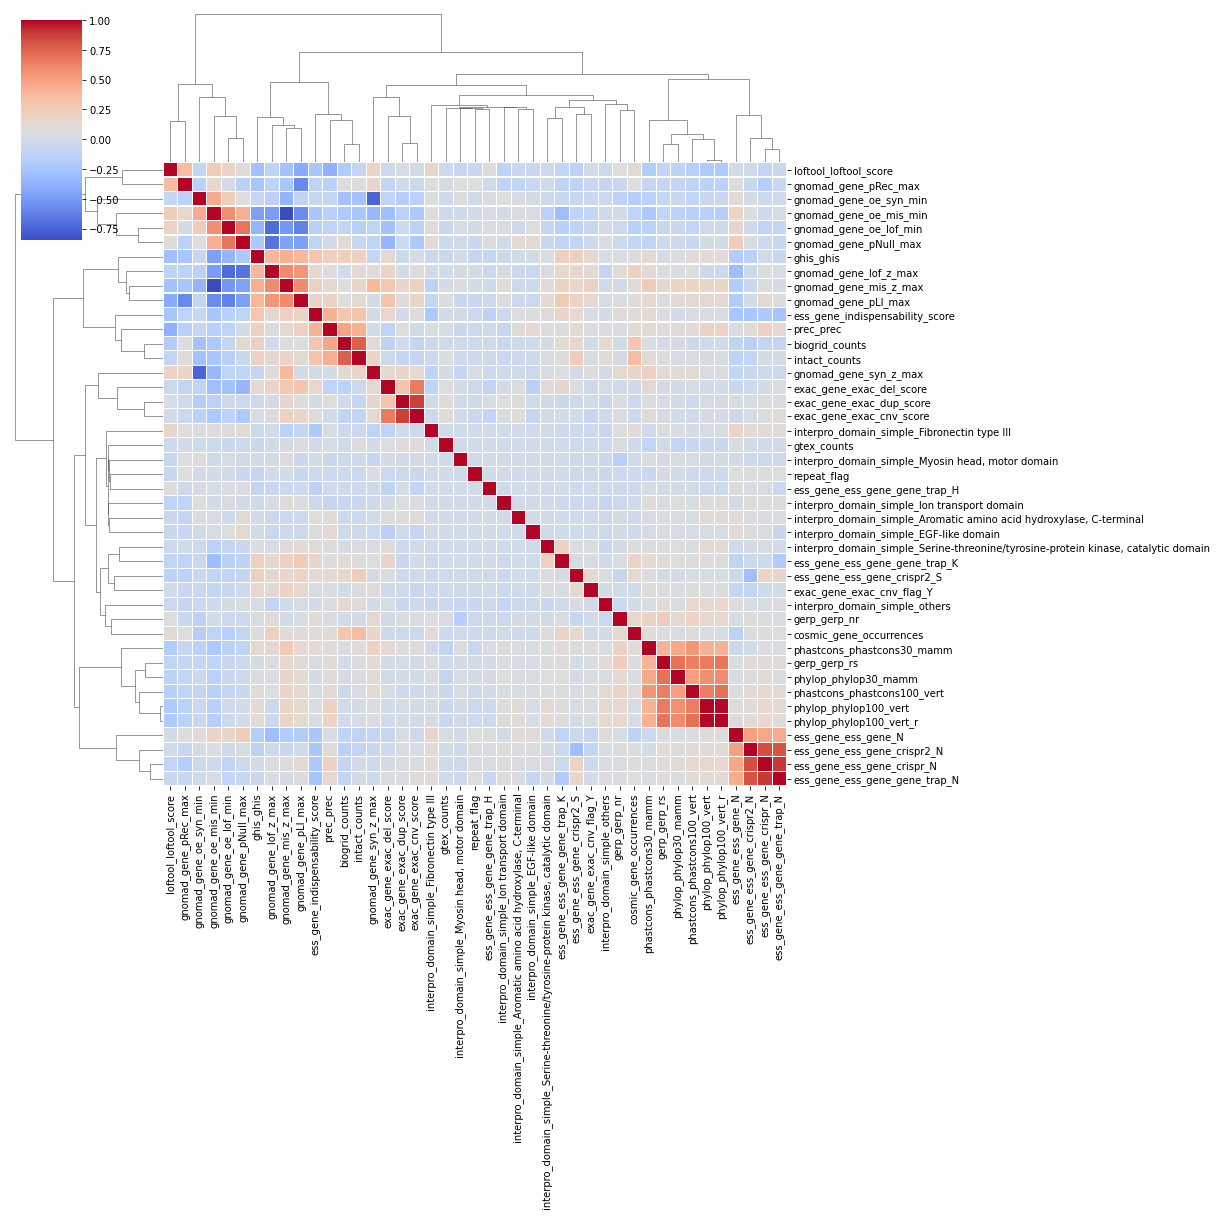

In [12]:
corr = Xdummy.corr()

cg = sns.clustermap(corr.fillna(0), cmap ='coolwarm', linewidths = 0.2,
                    method = 'complete', xticklabels=1,figsize = (17,17)) 
cg

##  Clustering?

*  No es el foco del curso ahora, pero es útil entender la estructura de los features.

## Recomiendo fuertemente utilizar R para TODO lo que sea clustring





### Qué proporción de Nulls hay en las variables? 
* Cómo podemos tratar esos Nulls?
* Un modelo como regresion logística (LR) no admite Nulls. 
* Hay que imputarlos. 
  * La estrategia más simple sería con el valor medio de ese feature en el dataset. Pero, eso es robusto a outliers?  
  * Y si usamos la Mediana?

### Cómo  se mueve la escala de las distintas variables?
* Algunos modelos (como la LR) requieren normalizar/escalar las variables. 
* Otros, como los árboles son insensibles a la escala de los features y NO requieren normalización.
* Hay distintos métodos de normalización/scaling.  

### Además, se puede (y deberíamos hacerlo) extender el análisis de los datos previo con:  
* PCA
* Significancia estadística de las correlaciones halladas.
* Entender qué tipo distribución tienen nuestras variables
* etc. 



### Finalmente, preparo sets de entrenamiento:
* Porcentajes arbitrarios, sólo basados en la práctica y son dependientes de la cantidad de datos. 

* Training  Set (50%)         #Estos  lo usamos para entrenar el modelo
    * Contendrá al evaluation set (lo sacaremos vía validación cruzada)   

* Test Set 50%.              #Este no lo tocamos nunca para entrenar ni para totmar decisiones. Es nuestra medida no sesgada del error de generalización



